In [7]:
%pip install tensorflow tensorflow-datasets matplotlib ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# Import dependences
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

# Prepare the data pipeline

In this section I will download the data and prepare the data pipeline to the TF dataset. I will also create a label map dict to map the 0 and 1 encodings onto cats and dogs respectively.


In [10]:
# Download dataset
ds = tfds.load("cats_vs_dogs", split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteXJ771P/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [11]:
# Set up an iterator for the data and a label map
ditr = ds.as_numpy_iterator()
label_map = {0: "cat", 1: "dog"}

# Verify we are getting images
data = ditr.next()
img = data["image"]
img_label = label_map[data["label"]]
display(f"The following image is of size {img.shape}")
display(img)

'The following image is of size (262, 350, 3)'

array([[[242, 248, 248],
        [240, 246, 246],
        [235, 239, 238],
        ...,
        [188, 174, 127],
        [145, 133,  85],
        [161, 149, 101]],

       [[238, 244, 244],
        [239, 245, 245],
        [235, 239, 238],
        ...,
        [188, 176, 128],
        [165, 153, 105],
        [178, 168, 119]],

       [[237, 241, 240],
        [238, 242, 241],
        [232, 236, 235],
        ...,
        [200, 187, 142],
        [201, 191, 142],
        [200, 192, 143]],

       ...,

       [[130, 122,  75],
        [152, 146,  98],
        [154, 148,  98],
        ...,
        [161, 166, 136],
        [ 77,  86,  57],
        [ 71,  82,  52]],

       [[167, 159, 112],
        [105,  99,  51],
        [148, 142,  92],
        ...,
        [ 67,  73,  45],
        [ 46,  56,  29],
        [ 41,  54,  26]],

       [[138, 130,  83],
        [ 83,  77,  29],
        [135, 129,  79],
        ...,
        [ 68,  74,  46],
        [ 14,  27,   1],
        [ 63,  77,  51]]

## Preprocess data

I don't have a GPU and the images are quite large (as seen above). I want to scale them down to 32x32 and also make them grayscale since I don't have the resources to train a model on a 3 channel image.


In [12]:
# Define preprocess function
def preprocess(img_data):
    img = img_data["image"]
    gimg = tf.image.rgb_to_grayscale(img)  # Convert to grayscale
    downscaled_img = tf.image.resize(
        gimg, [32, 32], antialias=True, method="lanczos3"
    )  # Scale to 32x32
    downscaled_img = downscaled_img / 255  # Also put values betwee 0 and 1
    return downscaled_img

In [40]:
ds = tfds.load("cats_vs_dogs", split="train")
# Apply preprocess to images in the data set
ds = ds.map(preprocess)
ds = ds.cache()
ds = ds.shuffle(10000)
ds = ds.batch(128)  # Bacth into 128 images per sample
ds = ds.prefetch(64)  # Prefetch around half a batch

ditr = ds.as_numpy_iterator()  # Update the iterator

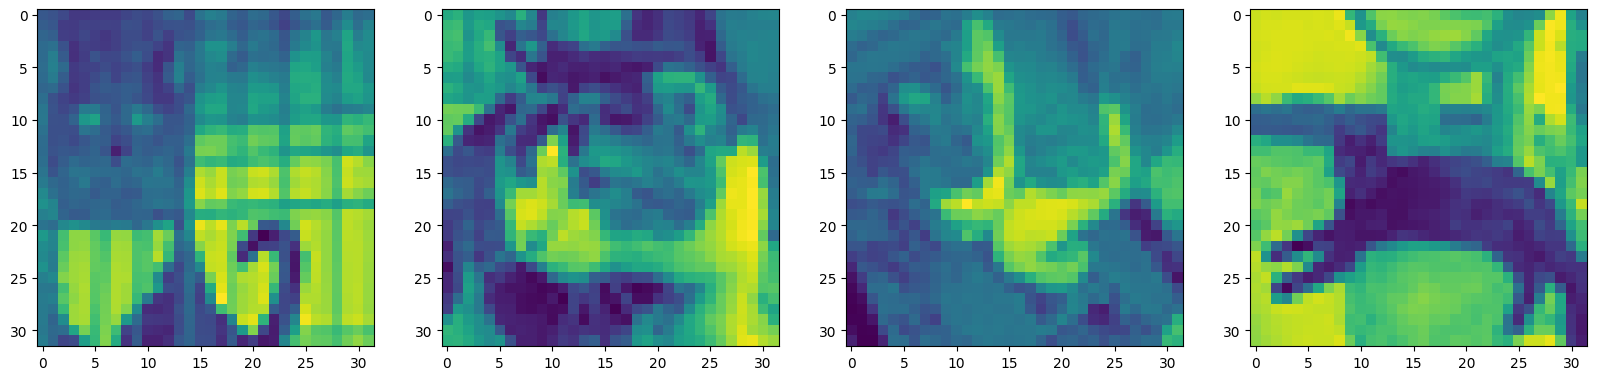

In [41]:
# Visualize the images in the datasets 4 images from 4 batches
fix, ax = plt.subplots(ncols=4, figsize=(20, 20))
for i in range(4):
    img = np.squeeze(ditr.next()[0])
    ax[i].imshow(img)

# Building a Deep Neural Network

In this section I will build the generator and the discriminator.


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Flatten,
    Reshape,
    LeakyReLU,
    Dropout,
    UpSampling2D,
)

## Generator


In [43]:
def build_generator():
    model = Sequential()

    # The latent space is defined as 7x7x128
    model.add(Dense(8 * 8 * 128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((8, 8, 128)))

    # Upsample #1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding="same"))  # Learn 128 filters
    model.add(LeakyReLU(0.2))

    # Upsampling #2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding="same"))  # Learn 128 filters
    model.add(LeakyReLU(0.2))

    # Convo block
    model.add(Conv2D(128, 4, padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, 4, padding="same"))
    model.add(LeakyReLU(0.2))

    # ! filter convo2d to learn output in the desired format
    model.add(Conv2D(1, 4, padding="same", activation="sigmoid"))  # Learn 128 filters

    return model

In [44]:
# Visualize the model
generator_model = build_generator()
generator_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              1056768   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                      

## Discriminator


In [45]:
def build_discriminator():
    model = Sequential()

    # Convo Block #1
    model.add(Conv2D(32, 5, input_shape=(32, 32, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convo Block #2
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convo Block #3
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convo Block #4
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten and output to one output neuron
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))

    return model

In [46]:
discriminator_model = build_discriminator()
discriminator_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 dropout_4 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 24, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 24, 24, 64)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 20, 20, 128)      

# Training

Here the generator and discriminator are trained simultaneously.


In [47]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [48]:
from tensorflow.keras.models import Model


class CatGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    def compile(
        self,
        generator_opt,
        discriminator_opt,
        generator_loss,
        discriminator_loss,
        *args,
        **kwargs
    ):
        super().compile(*args, **kwargs)

        self.generator_opt = generator_opt
        self.discriminator_opt = discriminator_opt
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss

    def train_step(self, batch):
        real_imgs = batch
        fake_imgs = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train discriminator
        with tf.GradientTape() as discriminator_tape:
            # Get discriminator predictors
            y_pred_real = self.discriminator(real_imgs, training=True)
            y_pred_fake = self.discriminator(fake_imgs, training=True)
            y_pred = tf.concat([y_pred_real, y_pred_fake], axis=0)

            # Keep track of which ones are real and fake for actual y
            y = tf.concat(
                [tf.zeros_like(y_pred_real), tf.ones_like(y_pred_fake)], axis=0
            )  # Fake = 1. So the model says "yes it is fake"

            # Add noise to true y
            noise = 0.15 * tf.random.uniform(tf.shape(y))
            y = y + noise # Add noise to each y

            # Loss
            total_discriminator_loss = self.discriminator_loss(y, y_pred)

        discriminator_gradient = discriminator_tape.gradient(
            total_discriminator_loss, self.discriminator.trainable_variables
        )
        self.discriminator_opt.apply_gradients(
            zip(discriminator_gradient, self.discriminator.trainable_variables)
        )

        # Train generator
        with tf.GradientTape() as generator_tape:
            gen_imgs = self.generator(tf.random.normal((128, 128, 1)), training=True)

            # Predict if fake from usining the discriminator
            discriminator_y_pred = self.discriminator(gen_imgs, training=False)

            # We want the discriminator to say 0 because it means we tricked the discriminator
            total_generator_loss = self.generator_loss(
                tf.zeros_like(discriminator_y_pred), discriminator_y_pred
            )

        generator_gradient = generator_tape.gradient(
            total_generator_loss, self.generator.trainable_variables
        )
        self.generator_opt.apply_gradients(
            zip(generator_gradient, self.generator.trainable_variables)
        )

        return {
            "discriminator_loss": total_discriminator_loss,
            "generator_loss": total_generator_loss,
        }

In [49]:
# Set up optimization and loss functions
generator_opt = Adam(learning_rate=0.0001)
discriminator_opt = Adam(learning_rate=0.00001)
generator_loss = BinaryCrossentropy()
discriminator_loss = BinaryCrossentropy()

# Initialize the model
catgan = CatGAN(generator_model, discriminator_model)
catgan.compile(generator_opt, discriminator_opt, generator_loss, discriminator_loss)

## Set up a Model Monitor


In [50]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [51]:
class CatGANMonitor(Callback):
    def __init__(self, img_count=3, latent_dim=128):
        self.img_count = img_count
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.img_count, self.latent_dim), 1)
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 255
        generated_images.numpy()

        for i in range(self.img_count):
            img = array_to_img(generated_images[i])
            img.save(os.path.join("./catgan_images/", f"epoch_{epoch}_img{i}.png"))

In [52]:
# Start training
monitor = CatGANMonitor()
hist = catgan.fit(ds, epochs=15, callbacks=[monitor])

Epoch 1/15
182/182 [==============================] - 132s 390ms/step - discriminator_loss: 0.5134 - generator_loss: 0.7328
Epoch 2/15
182/182 [==============================] - 59s 325ms/step - discriminator_loss: 0.2525 - generator_loss: 5.2154
Epoch 3/15
182/182 [==============================] - 59s 326ms/step - discriminator_loss: 0.5652 - generator_loss: 2.0344
Epoch 4/15
182/182 [==============================] - 59s 324ms/step - discriminator_loss: 0.6230 - generator_loss: 2.6565
Epoch 5/15
182/182 [==============================] - 59s 325ms/step - discriminator_loss: 0.6537 - generator_loss: 0.7766
Epoch 6/15
182/182 [==============================] - 60s 328ms/step - discriminator_loss: 0.7088 - generator_loss: 0.6586
Epoch 7/15
182/182 [==============================] - 60s 327ms/step - discriminator_loss: 0.7041 - generator_loss: 0.7044
Epoch 8/15
182/182 [==============================] - 59s 325ms/step - discriminator_loss: 0.6938 - generator_loss: 0.7301
Epoch 9/15
182/